# Implementation of BB84 on Starmon-5

In [1]:
###                                                   IMPORTING LIBRARIES
import time
import os
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import math as m
import operator as op
from functools import reduce
from math import ceil
from itertools import product

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import plot_histogram

from quantuminspire.credentials import get_authentication
from quantuminspire.credentials import save_account
from quantuminspire.qiskit import QI

In [2]:
###                                             CONNECTING TO QUANTUM INSPIRE
save_account('a2c6982402352e8e4b3bcabb8e89d7ec75d93003')
QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')
authentication = get_authentication()
QI.set_authentication(authentication, QI_URL,project_name='BB84 Simulation1')
qi_backend = QI.get_backend('QX-34-L')                                       # <--- Set the backend (default is Starmon-5)

## BB84 With Quantum Randomness (only possible on simulators)

In [3]:
def IntrinsicQuantumBB84Circuit(numMeasurements, isEve):
   
    """
    Circuit Generator
    
    For Starmon5 purposes only
    
    p.....Probability that Eve gets the qubit
    """
    q = QuantumRegister(5)
    ans = ClassicalRegister(5)
    qc = QuantumCircuit(q, ans)
    
    qc.h(q[0])
    qc.h(q[1])
    qc.h(q[2])

    qc.measure(q[0],ans[0])
    qc.measure(q[1],ans[1])
    qc.measure(q[2],ans[2])

    for level in range(numMeasurements):
        
        qc.x(q[3]).c_if(ans[0],1)
        qc.h(q[3]).c_if(ans[1],1)
        qc.h(q[3]).c_if(ans[2],1)

        if isEve:
            qc.h(q[4])
            qc.measure(q[4],ans[4])
            qc.ch(q[4],q[2])
            qc.measure(q[2],ans[3])
            qc.ch(q[4],q[2])

        
        #qc.cry(-np.pi/2,q[3],q[2])
        qc.measure(q[3],ans[3])
        
        #qc.x(q[2]).c_if(ans[3],1)
        
        qc.barrier()
             
        #qc.cnot(q[0], q[2])
        #qc.cry(np.pi/2, q[1], q[2])
        #qc.cry(-np.pi/2, q[1],q[2])
        #qc.reset(q[2])

    return q, qc

### Quantum circuit when there is no Eve

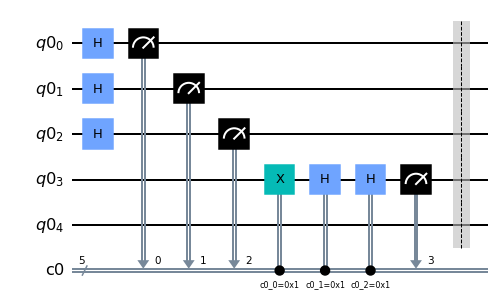

In [4]:
quantumResults, quantumCircuit = IntrinsicQuantumBB84Circuit(1, False)
quantumCircuit.draw(output='mpl')

### Quantum circuit when there is an Eve

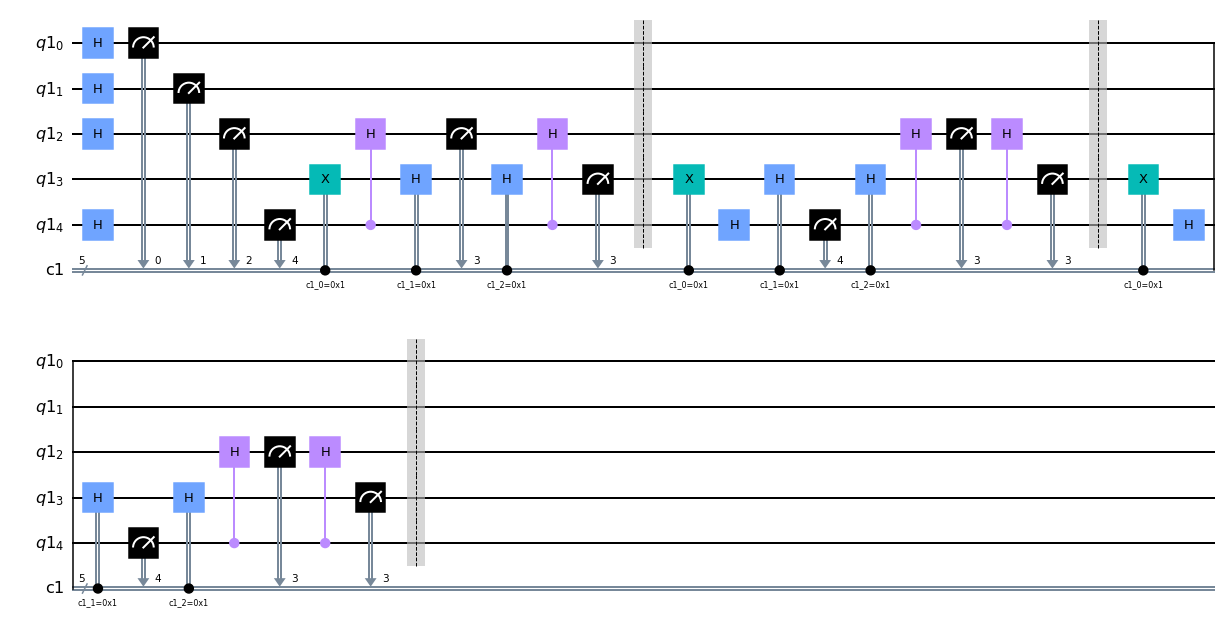

In [5]:
quantumResults, quantumCircuit = IntrinsicQuantumBB84Circuit(3, True)
quantumCircuit.draw(output='mpl')

## Function definitions

In [6]:
def BB84ProtocolQuantumRandom(messageLength, numMeasurements, isEve, Starmon):
    """
    Given the initial message length (int) it returns
    messageInABottle: randomly generated message to be communicated (A->B)
    AliceBasis: randomly generated Alice Basis (0:Z, 1:X)
    BobBasis: randomly generated Bob Basis (0:Z, 1:X)
    OutputString: either the result from the BB84 protocol if A&B have the same basis
    or an "x" if Basis(A) != Basis(B)! for each bit
    """
    
    if Starmon:
        qi_backend = QI.get_backend('Starmon-5')
    else:
        qi_backend = QI.get_backend('QX-34-L')
    
    n = 0
    messageInABottle = []
    AliceBasis = []
    BobBasis = []
    outputString = []
    sameBasisPositions = []
    quantumResults, quantumCircuit = IntrinsicQuantumBB84Circuit(numMeasurements, isEve)

    job = execute(quantumCircuit, qi_backend,shots=messageLength,memory=True)
    result = job.result()
    counts = result.get_counts()
    measure = result.get_memory()
    n_register = len(measure[0])-1
    #print(measure.shape)
    
    for n in range(messageLength):
        message_measurement = []
        AliceBasis_measurement = []
        BobBasis_measurement = []
        for m in range(numMeasurements):
            message_measurement.append(measure[n][(m+1)*n_register-0])
            AliceBasis_measurement.append(measure[n][(m+1)*n_register-1])
            BobBasis_measurement.append(measure[n][(m+1)*n_register-2])
            
        
        messageInABottle.append(int(max(set(message_measurement), key = message_measurement.count)))
        AliceBasis.append(int(max(set(AliceBasis_measurement), key = AliceBasis_measurement.count)))
        BobBasis.append(int(max(set(BobBasis_measurement), key = BobBasis_measurement.count)))
        
        if AliceBasis[n] == BobBasis[n]:
            outputString.append(int(measure[n][n_register-3]))
            sameBasisPositions.append(n)
        else:
            outputString.append("x")

    #print("Alice Basis:",AliceBasis)
    #print("Bob Basis:", BobBasis)
    return messageInABottle, AliceBasis, BobBasis, outputString, sameBasisPositions



In [7]:
def BB84KeyConstruction(message,output,goodIndices,prop,tolerance,explanation):
    """
    message: Alice starting message
    output: Bob's result through Quantum Magic
    goodIndices: bit Positions in which both basis are the same    
    prop: Proportion of common good bits to be compared
    tolerance: minimum success rate to generate a safe QK
    explanation: bool argument, if True, prints stuff

    """
    auxList = []    
    nGoodBits = len(goodIndices)
    
    
    nComparingBits = int(nGoodBits*prop)
    comparingBitPositions = rand.sample(goodIndices, nComparingBits)
    if explanation:
        print("Bit Positions to compare: ",comparingBitPositions)
    
    allOkCounter = 0
    for i in range(nComparingBits):
        j = comparingBitPositions[i]
        if int(message[j])== int(output[j]):
            allOkCounter +=1
            
    for i in range(nGoodBits):
        if i not in comparingBitPositions:
            auxList.append(output[goodIndices[i]])
    
    #print(allOkCounter)
    if nComparingBits == 0:
        successRate = 1 
    else:
        successRate = float(allOkCounter/nComparingBits)
    
    if successRate < tolerance:
        print("Success rate: ",successRate)
        print("Failure")
        if explanation:
            print("Message:", message)
            print("Bob's measurements:", output)
        return successRate
    else:
        print("Success rate: ",successRate)
        print("Success!!!")
        if explanation:
            print("Message:", message)
            print("Bob's measurements:", output)
        print("QKD: ", auxList)
        return auxList

## Protocol execution

In [8]:
messageLength = 1000
prop = 0.8
tolerance = 0.8
Eve = False
Starmon = True

messageInABottle, AliceBasis, BobBasis, messageOutput, goodIndices = BB84ProtocolQuantumRandom(messageLength, 1, Eve,Starmon)

QKD = BB84KeyConstruction(messageInABottle,messageOutput,goodIndices,prop,tolerance,explanation=False)

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.4801980198019802
Failure


In [39]:
succesrates = []
for i in range(20):
    messageInABottle, AliceBasis, BobBasis, messageOutput, goodIndices = BB84ProtocolQuantumRandom(messageLength,Eve,Starmon)
    QKD = BB84KeyConstruction(messageInABottle,messageOutput,goodIndices,prop,tolerance,explanation=False)
    succesrates.append(QKD)

print('Average succes rate:            ' + str(round(np.mean(succesrates),3)))
print('Standard deviation succes rate: ' + str(round(np.std(succesrates),3)))

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.56884765625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58837890625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.56787109375
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58544921875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58837890625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.576171875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.56982421875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58251953125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58642578125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.5810546875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58642578125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.57275390625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.5830078125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.5810546875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.564453125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.57080078125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.57421875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.57421875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.56640625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.556640625
Failure
Average succes rate:            0.576
Standard deviation succes rate: 0.009


# BB84 Without Quantum Randomness

In [8]:
def BB84Circuits(AliceBasis, BobBasis, message):
   
    """
    Circuit Generator
    
    AliceBasis: nqubits-length array with entries 0 (z basis) or 1 (x basis)
    BobBasis: nqubits-length array with entries 0 (z basis) or 1 (x basis)
    message: nqubits-length binary array
    """
    q = QuantumRegister(5)
    ans = ClassicalRegister(1)
    qc = QuantumCircuit(q, ans)
    
    if AliceBasis == 0:
        if message == 1:
            qc.x(q[2])
    elif AliceBasis == 1:
        if message == 0:
            qc.h(q[2])
        elif message == 1:
            qc.x(q[2])
            qc.h(q[2])
            
    qc.barrier()
    
    if BobBasis == 0:
        qc.measure(q[2], ans[0])
    elif BobBasis == 1:
        qc.h(q[2])
        qc.measure(q[2], ans[0])
    
    return q, qc

def EveBB84Circuits(AliceBasis, BobBasis, message, EveStrat):
   
    """
    Circuit Generator

    AliceBasis: nqubits-length array with entries 0 (z basis) or 1 (x basis)
    BobBasis: nqubits-length array with entries 0 (z basis) or 1 (x basis)
    message: nqubits-length binary array
    """
    q = QuantumRegister(5)
    ans = ClassicalRegister(1)
    qc = QuantumCircuit(q, ans)
    
    if AliceBasis == 0:
        if message == 1:
            qc.x(q[2])
    elif AliceBasis == 1:
        if message == 0:
            qc.h(q[2])
        elif message == 1:
            qc.x(q[2])
            qc.h(q[2])
    
    qc.barrier()

    if EveStrat == 'H':
        qc.h(q[2])
        qc.measure(q[2], ans[0])
        qc.h(q[2])
    elif EveStrat == 'X':
        qc.measure(q[2],ans[0])
    elif EveStrat == '-':
        pass
        #Do Nothing#
    
    qc.barrier()
    
    if BobBasis == 0:
        qc.measure(q[2], ans[0])
    elif BobBasis == 1:
        qc.h(q[2])
        qc.measure(q[2], ans[0])
    
    return q, qc   

#the four cases
def E91Circuit_1(messageLength):
    
    """
    For Starmon5 purposes only 
    """
    
    q = QuantumRegister(5)
    ans = ClassicalRegister(5)
    qc = QuantumCircuit(q, ans)
    
    #Entanglement creation
    qc.h(q[1])
    qc.cnot(q[1],q[2])
    
#    qc.x(q[1])
    qc.barrier(q[1])
    qc.barrier(q[2])
    
    
    #Alice basis: 0 (Z)    
    #Measurements of Alice q[1] and Bob q[2] performed
    qc.measure(q[1],ans[1])
    qc.measure(q[2],ans[2])
    
    


    
    return q,qc


def E91Circuit_2(messageLength):
    
    """
    For Starmon5 purposes only 
    """
    
    q = QuantumRegister(5)
    ans = ClassicalRegister(5)
    qc = QuantumCircuit(q, ans)
    
    
    #Entanglement creation
    qc.h(q[1])
    qc.cnot(q[1],q[2])
    
    qc.barrier(q[1])
    qc.barrier(q[2])
    
    #Alice basis: 1 (X)
    
    qc.h(q[1])
    
    
    #Measurements of Alice q[1] and Bob q[2] performed
    qc.measure(q[1],ans[1])
    qc.measure(q[2],ans[2])
    
    return q,qc

def E91Circuit_3(messageLength):
    
    """
    For Starmon5 purposes only 
    """
    
    q = QuantumRegister(5)
    ans = ClassicalRegister(5)
    qc = QuantumCircuit(q, ans)
    
    
    #Entanglement creation
    qc.h(q[1])
    qc.cnot(q[1],q[2])
    
    qc.barrier(q[1])
    qc.barrier(q[2])
    
    
    #Bob basis: 1 (X)
    qc.h(q[2])

    
    #Measurements of Alice q[1] and Bob q[2] performed
    qc.measure(q[1],ans[1])
    qc.measure(q[2],ans[2])
      
    return q,qc

def E91Circuit_4(messageLength):
    
    """
    For Starmon5 purposes only 
    """
    
    q = QuantumRegister(5)
    ans = ClassicalRegister(5)
    qc = QuantumCircuit(q, ans)
    
    
    #Entanglement creation
    qc.h(q[1])
    qc.cnot(q[1],q[2])
    
    qc.barrier(q[1])
    qc.barrier(q[2])
    
    #Alice basis: 1 (X)
    
    qc.h(q[1])
    
    #Bob basis: 1 (X)
    qc.h(q[2])


    
    #Measurements of Alice q[1] and Bob q[2] performed
    qc.measure(q[1],ans[1])
    qc.measure(q[2],ans[2])
    
    


    
    return q,qc

def SimBB84Circuit(err_rate):
    q = QuantumRegister(5)
    ans = ClassicalRegister(1)
    qc = QuantumCircuit(q, ans)
    
    if AliceBasis == 0:
        if message == 1:
            qc.x(q[2])
    elif AliceBasis == 1:
        if message == 0:
            qc.h(q[2])
        elif message == 1:
            qc.x(q[2])
            qc.h(q[2])
            
    qc.barrier()
    
    if BobBasis == 0:
        qc.rx()
        qc.measure(q[2], ans[0])
    elif BobBasis == 1:
        qc.h(q[2])
        qc.measure(q[2], ans[0])
    
    return q, qc

In [9]:
qi_backend = QI.get_backend('Starmon-5')
Fidelity1 = np.zeros(10)
Fidelity2 = np.zeros(10)
for i in range(10):    
    q1,qc1 = E91Circuit_1(0)
    q4,qc4 = E91Circuit_4(0)
    
    job = execute(qc1, qi_backend, shots=16384)
    result = job.result()
    counts = result.get_counts()
    
    Fidelity1[i] = (counts['00000']+counts['00110'])/16384
    
    job = execute(qc4, qi_backend, shots=16384)
    result = job.result()
    counts = result.get_counts()
    
    Fidelity2[i] = (counts['00000']+counts['00110'])/16384
    
    print('Fidelity1:', Fidelity1[i])
    print('Fidelity2:', Fidelity2[i])
    print('')

KeyboardInterrupt: 

In [19]:
print('Basis = 0 --> Fidelity:',np.mean(Fidelity1),'and error: ',np.std(Fidelity1)/np.sqrt(10))
print('Basis = 1 --> Fidelity:',np.mean(Fidelity2),'and error: ',np.std(Fidelity2)/np.sqrt(10))

Basis = 0 --> Fidelity: 0.931060791015625 and error:  0.002237440107652176
Basis = 1 --> Fidelity: 0.904205322265625 and error:  0.0006936156108356155


Alice bit: 0 ; Alice basis: 0 ; Bob Basis: 0


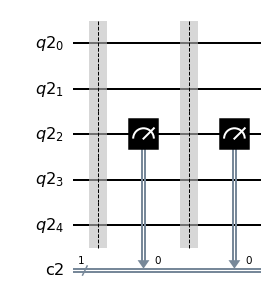

Alice bit: 1 ; Alice basis: 0 ; Bob Basis: 0


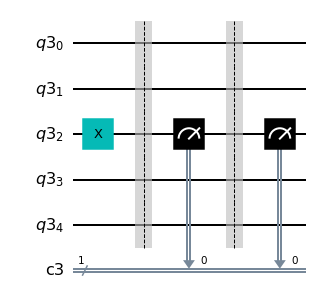

Alice bit: 0 ; Alice basis: 0 ; Bob Basis: 1


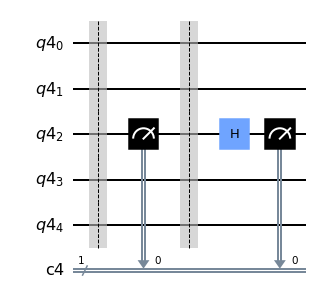

Alice bit: 1 ; Alice basis: 0 ; Bob Basis: 1


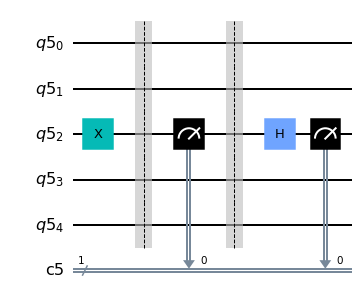

Alice bit: 0 ; Alice basis: 1 ; Bob Basis: 0


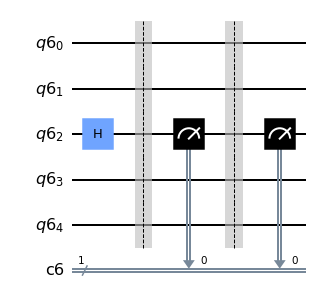

Alice bit: 1 ; Alice basis: 1 ; Bob Basis: 0


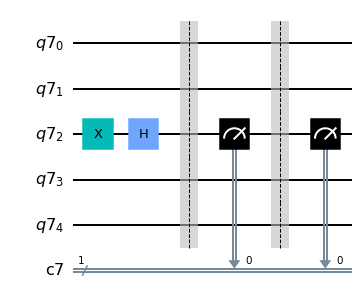

Alice bit: 0 ; Alice basis: 1 ; Bob Basis: 1


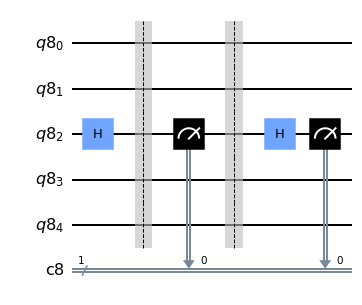

Alice bit: 1 ; Alice basis: 1 ; Bob Basis: 1


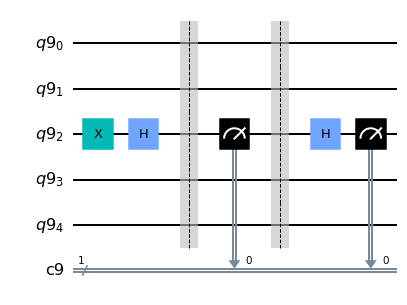

In [9]:
qi_backend = QI.get_backend('QX-34-L')
for AliceBasis in [0,1]:
    for BobBasis in [0,1]:
        for AliceBit in [0,1]:
            #if AliceBasis == BobBasis:
            q, qc = EveBB84Circuits(AliceBasis,BobBasis,AliceBit,'X') #AliceBasis, BobBasis, message
            print('Alice bit: '+str(AliceBit)+' ; Alice basis: '+str(AliceBasis)+' ; Bob Basis: '+str(BobBasis))
            display(qc.draw(output='mpl'))

In [13]:
Fidelity00 = np.zeros(10)
Fidelity01 = np.zeros(10)
Fidelity10 = np.zeros(10)
Fidelity11 = np.zeros(10)
for AliceBit in [0,1]:
    for Basis in [0,1]:
        for i in range(10):
            q,qc = BB84Circuits(Basis,Basis,AliceBit)
            qi_backend = QI.get_backend('Starmon-5')
            job = execute(qc, qi_backend, shots=16384)
            result = job.result()
            counts = result.get_counts()
            if AliceBit == 0 and Basis == 0:
                Fidelity00[i] += counts['0']/16384
            if AliceBit == 0 and Basis == 1:
                Fidelity01[i] += counts['0']/16384
            if AliceBit == 1 and Basis == 0:
                Fidelity10[i] += counts['1']/16384
            if AliceBit == 1 and Basis == 1:
                Fidelity11[i] += counts['1']/16384

print('AliceBasis = 0 and Basis = 0 --> Fidelity:',np.mean(Fidelity00),'and stdev: ',np.std(Fidelity00))
print('AliceBasis = 0 and Basis = 1 --> Fidelity:',np.mean(Fidelity01),'and stdev: ',np.std(Fidelity01))
print('AliceBasis = 1 and Basis = 0 --> Fidelity:',np.mean(Fidelity10),'and stdev: ',np.std(Fidelity10))
print('AliceBasis = 1 and Basis = 1 --> Fidelity:',np.mean(Fidelity11),'and stdev: ',np.std(Fidelity11))

AliceBasis = 0 and Basis = 0 --> Fidelity: 0.99412841796875 and stdev:  0.0008031632885544912
AliceBasis = 0 and Basis = 1 --> Fidelity: 0.986187744140625 and stdev:  0.0005790625007411177
AliceBasis = 1 and Basis = 0 --> Fidelity: 0.958935546875 and stdev:  0.0013769617824417554
AliceBasis = 1 and Basis = 1 --> Fidelity: 0.943994140625 and stdev:  0.0016563371599403584


In [14]:
print('AliceBasis = 0 and Basis = 0 --> Fidelity:',np.mean(Fidelity00),'and stdev: ',np.std(Fidelity00)/np.sqrt(10))
print('AliceBasis = 0 and Basis = 1 --> Fidelity:',np.mean(Fidelity01),'and stdev: ',np.std(Fidelity01)/np.sqrt(10))
print('AliceBasis = 1 and Basis = 0 --> Fidelity:',np.mean(Fidelity10),'and stdev: ',np.std(Fidelity10)/np.sqrt(10))
print('AliceBasis = 1 and Basis = 1 --> Fidelity:',np.mean(Fidelity11),'and stdev: ',np.std(Fidelity11)/np.sqrt(10))

AliceBasis = 0 and Basis = 0 --> Fidelity: 0.99412841796875 and stdev:  0.00025398253248632373
AliceBasis = 0 and Basis = 1 --> Fidelity: 0.986187744140625 and stdev:  0.0001831156409934872
AliceBasis = 1 and Basis = 0 --> Fidelity: 0.958935546875 and stdev:  0.0004354335483521195
AliceBasis = 1 and Basis = 1 --> Fidelity: 0.943994140625 and stdev:  0.0005237797998586135


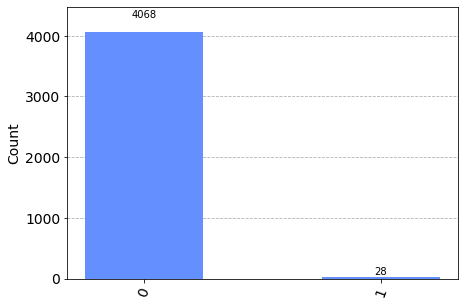

In [14]:
plot_histogram(result.get_counts())

## Fidelity estimations for the 8 possible circuits

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 0
Alice's basis: 0
Bob's basis: 0
Fidelity: 0.99669


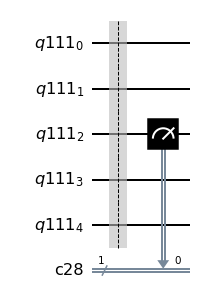

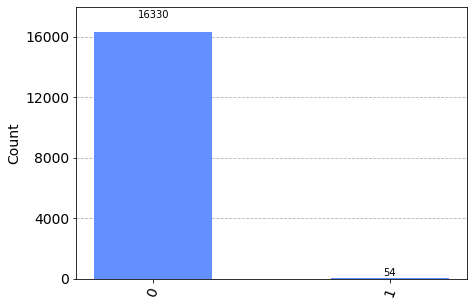

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 1
Alice's basis: 0
Bob's basis: 0
Fidelity: 0.95928


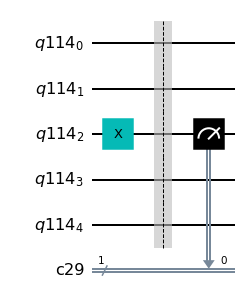

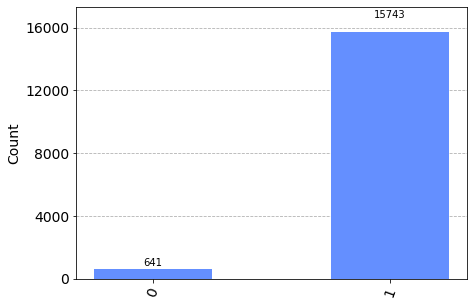

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 0
Alice's basis: 0
Bob's basis: 1


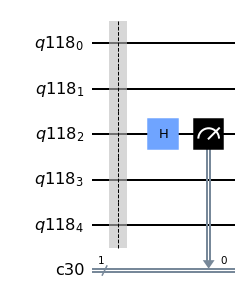

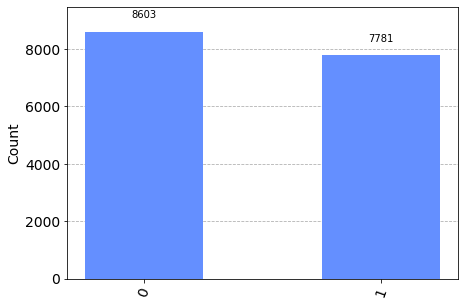

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 1
Alice's basis: 0
Bob's basis: 1


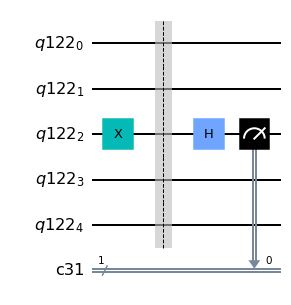

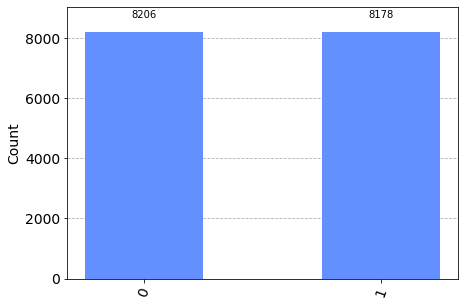

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 0
Alice's basis: 1
Bob's basis: 0


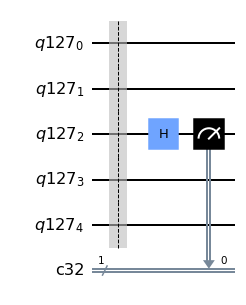

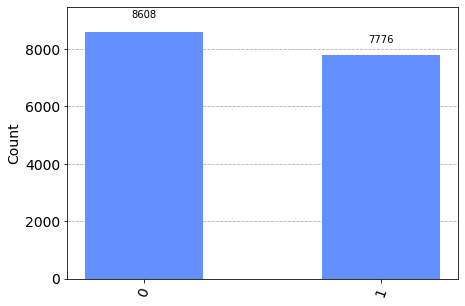

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 1
Alice's basis: 1
Bob's basis: 0


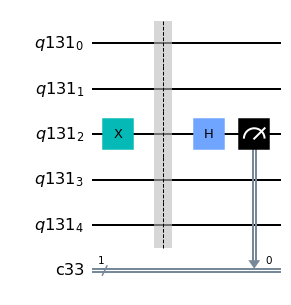

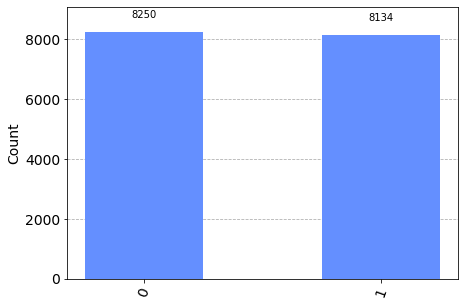

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 0
Alice's basis: 1
Bob's basis: 1
Fidelity: 0.99608


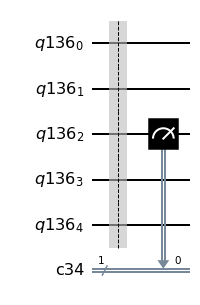

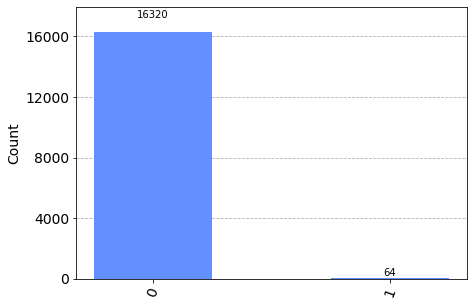

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 1
Alice's basis: 1
Bob's basis: 1
Fidelity: 0.95994


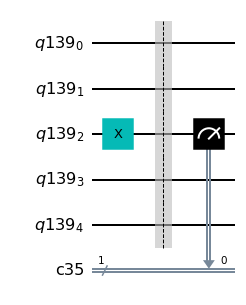

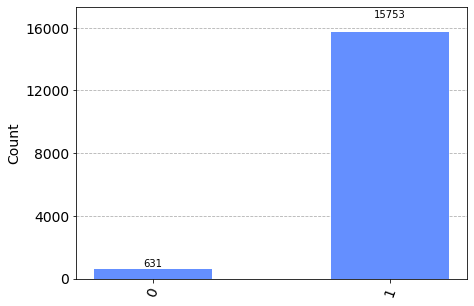

In [22]:
qi_backend = QI.get_backend('Starmon-5')

for AliceBasis in [0,1]:
    for BobBasis in [0,1]:
        for AliceBit in [0,1]:
            q,qc = BB84Circuits(AliceBasis, BobBasis, AliceBit)
            
            job = execute(qc, qi_backend,shots=16384)
            result = job.result()
            counts = result.get_counts()
            print("Alice's bit: "+str(AliceBit))
            print("Alice's basis: "+str(AliceBasis))
            print("Bob's basis: "+str(BobBasis))
            if BobBasis == AliceBasis:
                counts_0 = counts['0']
                counts_1 = counts['1']
                error = min(counts_0/counts_1, counts_1/counts_0)
                print("Fidelity: "+str(round(1-error,5)))
            display(qc.draw(output='mpl'))
            display(plot_histogram(result.get_counts(qc)))            

In [10]:
def TableGenerator(MesString,AliBasString,BobBasString,MeasString):
    #Intput: 4 arrays of 02 or 1s of same length
    #Output: Merge them into a table
    
    Table = np.zeros([4,len(MesString)])
    Table[0,:] = MesString
    Table[1,:] = AliBasString
    Table[2,:] = BobBasString
    Table[3,:] = MeasString
    
    return Table

def TableShuffler(Table):
    #Input: Table, a 4xn_iter array
    #Output: Table Shuffled in columns (permutation)
    rng = np.random.default_rng()
    Shuffled = np.transpose(rng.permutation(np.transpose(Table)))
    return Shuffled

def TableFiltering(Table):
    #Input Table, a 4xn_iter array
    #Output: Table Filtered: Only those columns in which
    #Alice Basis = Bob Basis
    #i = 0: Alice Message
    #i = 1: Alice Basis
    #i = 2: Bob Basis
    #i = 3: Bob Measures
    SameBasisTable = np.zeros([4,1])
    for i in range(len(Table[0,:])):
        if Table[1,i] == Table[2,i]:
            newcol = np.zeros([4,1])
            for j in range(4):
                newcol[j,0]=Table[j,i]
            SameBasisTable = np.append(SameBasisTable,newcol,axis=1)
    SameBasisTable = np.delete(SameBasisTable,0,axis=1)
    return SameBasisTable

def TableSampling(Table,frac=0.1):
    #Extracts a sample to caclulate the raw probability of failure and expose Eve, if present
    #Input: Table to work upon, fraction of the columns devoted to sampling
    random_indx = np.random.randint(0,len(Table[0,:]),int(frac*len(Table[0,:])))
    SampleTable = Table[:,random_indx]
    
    sum = 0
    for i in range(len(SampleTable[0,:])):
        if SampleTable[0,i]==SampleTable[3,i]:
            sum +=1
    
    rawSuccessRate = sum/float(len(SampleTable[0,:]))
    
    newTable = Table
    newTable = np.delete(Table,random_indx,axis=1)
    
    return newTable, SampleTable, rawSuccessRate

def TableReorganisation(Table,n_rep):
    #Input: Filtered Table, number of iterations for repetition code
    #Output: Reorganised table by columns in groups of n_rep
    newTable = Table
    index_row = np.zeros(len(Table[0,:]),dtype = int)
    index_now = 0
    index_list = []
    for i in range(len(Table[0,:])):
        #print(i,"/",len(Table[0,:]))
        #print(index_row)
        if index_row[i] != 0:
            continue
        else:
            index_row[i] = index_now
            index_list.append(i)
            column_counter = 1
            leap = 1
            while column_counter < n_rep and i + leap < len(Table[0,:]): #We have not found all the columns or we have run out of columns
                if Table[0,i]==Table[0,i+leap] and Table[1,i]==Table[1,i+leap] and Table[1,i]==Table[1,i+leap]:
                    index_now += 1
                    column_counter += 1
                    index_row[i+leap] = index_now
                    index_list.append(i+leap)
                leap += 1
            index_now +=1
    
    #Table Reorganisation
    newTable[:] = Table[:,index_list]
    
    
    return newTable

def TableMajorityVoting(Table,n_rep):
    #Given the reorganised table, merges the columns applying majority voting
    newTable = np.zeros([4,1])
    i = 0
    leap = 0
    while i + leap < len(Table[0,:]):
        newcol = np.zeros([4,1])
        for j in range(3):
            newcol[j,0]=Table[j,i]
        leap = 0
        cache = []
        while i + leap < len(Table[0,:]) and Table[0,i]==Table[0,i+leap] and Table[1,i]==Table[1,i+leap] and  leap <n_rep:
            cache.append(Table[3,i+leap])
            leap += 1
        
        #Majority voting
        if len(cache) == n_rep:
            if cache.count(0) > cache.count(1):
                newcol[3,0] = 0
            else:
                newcol[3,0]= 1
        
            newTable = np.append(newTable,newcol,axis=1)
        i = i+leap
    
    newTable = np.delete(newTable,0,axis=1)
    
    return newTable

def NewStrings(Table):
    #Given the Mayority Voted Table, returns the new Alice Message and Bob Measures strings
    newAliceString = Table[0,:]
    newBobString = Table[3,:]
    
    return newAliceString,newBobString

def WholeRepetitionProcedure(AliceMess,AliceBas,BobBas,BobMeasure,n_rep,checkingForEve = False):
    #Input: The 4 strings obtained through BB84 or E91 protocols, and how many repetition bits n_rep
    # boolean argument "checkingForEve" set to be false by defect
    
    #Output: The new AliceKey and BobKey after the repetition protocol
    # If checking for Eve, also the success rate before applying majority voting
    
    Table = TableGenerator(AliceMess,AliceBas,BobBas,BobMeasure)
    Shuffled = TableShuffler(Table)
    Filtered = TableFiltering(Shuffled)
    if checkingForEve:
        Sampled,Sample,rawSucRate = TableSampling(Filtered)
        Reorganised = TableReorganisation(Sampled,n_rep)
    else:
        Reorganised = TableReorganisation(Filtered,n_rep)

    Majority = TableMajorityVoting(Reorganised,n_rep)
    NewAliceKey, NewBobKey = NewStrings(Majority)
    
    if checkingForEve:
        return NewAliceKey,NewBobKey,rawSucRate
    else:
        return NewAliceKey,NewBobKey
        

def ProbOverallFailure(N, probSingleFailure):
    #using the repetition code and mayority voting for error correcting
    #with N repetitions devoted to a single logical bit transmission
    #with each one of the single iterations having a probability of failure
    
    #returns the overallprobability of failure
    sum_ = np.zeros(len(N))
    for j in range(len(N)):
        for i in range(int(N[j]/2+1),int(N[j]+1)):
            sum_[j] += ncr(int(N[j]),i)*m.pow(probSingleFailure,i)*m.pow(1-probSingleFailure,int(N[j])-i)

    return sum_


def ProbOverallFailure1(N, probSingleFailure):
    #using the repetition code and mayority voting for error correcting
    #with N repetitions devoted to a single logical bit transmission
    #with each one of the single iterations having a probability of failure
    
    #returns the overallprobability of failure
    sum_ = 0
    for i in range(int(N/2+1),int(N+1)):
        sum_ += ncr(int(N),i)*m.pow(probSingleFailure,i)*m.pow(1-probSingleFailure,int(N)-i)
    return sum_
def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

def NrepRequired(probSingleFailure,maxProbOverallFailure):
    #fixing the funciton attributes
    #returns the number of repetition bits required for:
    #probOverallFailure(probSingleFailure,NRepRequired) <= maxProbOverallFailure
    repBits = 1
    while(True):
        if maxProbOverallFailure >= ProbOverallFailure(probSingleFailure,repBits):
            break
        else:
            repBits += 2
    return repBits
        

In [10]:
print(ProbOverallFailure(0,3))

TypeError: object of type 'int' has no len()

In [11]:
def MeasurementProcedure(isEve,Starmon5,EveStrat):
    AliceMess = []
    AliceBas = []
    BobBas = []
    Message = []
    count = 1
    if Starmon5:
        qi_backend = QI.get_backend('Starmon-5')
        Nshots = 16384
    if not Starmon5:
        qi_backend = QI.get_backend('QX-34-L')
        Nshots = 4096
    counter = 0                
    for AliceBasis in [0,1]:
        for BobBasis in [0,1]:
            for AliceBit in [0,1]:
                print('Progress: ' +str(100*counter/8)+' %')
                counter += 1
                if isEve == False:
                    q,qc = BB84Circuits(AliceBasis, BobBasis, AliceBit)
                    job = execute(qc, qi_backend,memory=True, shots=Nshots)
                    result = job.result()
                    measure = result.get_memory()
                    for i in range(Nshots):
                        if i==0:
                            AliceMess.extend([AliceBit]*Nshots)
                            AliceBas.extend([AliceBasis]*Nshots)
                            BobBas.extend([BobBasis]*Nshots)
                        Message.append(measure[i][0])
                        
                elif isEve == True:
                    q,qc = EveBB84Circuits(AliceBasis, BobBasis, AliceBit, EveStrat)
                    job = execute(qc, qi_backend,memory=True, shots=Nshots)
                    result = job.result()
                    measure = result.get_memory()
                    for i in range(Nshots):
                        if i==0:
                            AliceMess.extend([AliceBit]*Nshots)
                            AliceBas.extend([AliceBasis]*Nshots)
                            BobBas.extend([BobBasis]*Nshots)
                        Message.append(int(measure[i][0]))
                        
                else: #isEve is a float between 0 and 1!
                    q,qc = BB84Circuits(AliceBasis, BobBasis, AliceBit)
                    qE, qcE = EveBB84Circuits(AliceBasis, BobBasis, AliceBit, EveStrat)
                    N_EveMeasurements = int(Nshots*isEve)
                    
                    job = execute(qc, qi_backend,memory=True, shots=Nshots-N_EveMeasurements)
                    result = job.result()
                    measure1 = result.get_memory()
                    
                    job = execute(qcE, qi_backend,memory=True, shots=N_EveMeasurements)
                    result = job.result()
                    measure2 = result.get_memory()
                    
                    for i in range(Nshots):
                        if i==0:
                            AliceMess.extend([AliceBit]*Nshots)
                            AliceBas.extend([AliceBasis]*Nshots)
                            BobBas.extend([BobBasis]*Nshots)
                        if i<N_EveMeasurements:
                            Message.append(measure2[i][0])
                        else:
                            Message.append(measure1[i-N_EveMeasurements][0])
    return AliceMess, AliceBas, BobBas, Message

def ComparisonProtocol(prop, security, AliceMess, AliceBas, BobBas, Message):
    goodIndices = []
    for i in range(len(AliceMess)):
        if AliceBas[i] == BobBas[i]:
            goodIndices.append(i)
            
    nComparingBits = int(len(goodIndices)*prop)
    comparingBitPositions = rand.sample(goodIndices, nComparingBits)
    
    allOkCounter = 0
    for i in range(nComparingBits):
        j = comparingBitPositions[i]
        if int(Message[j]) == int(AliceMess[j]):
            allOkCounter +=1
                         
    succesRate = allOkCounter/nComparingBits
    n_rep = NrepRequired(1-succesRate,security)
    
    return succesRate, n_rep

def FinalEvaluation(AliceKey, BobKey):
    wrong_counter = 0
    for i in range(len(AliceKey)):
        if int(BobKey[i]) != int(AliceKey[i]):
            wrong_counter += 1
    Err_rate = float(wrong_counter)/len(AliceKey)
    return Err_rate


In [12]:
def BB84RepititionProtocol(propComparison, DesiredSecurity, isEve,Starmon5,EveStrat):
    AliceMess, AliceBas, BobBas, Message = MeasurementProcedure(isEve, Starmon5,EveStrat)
    
    succesRate, n_rep = ComparisonProtocol(propComparison, DesiredSecurity, AliceMess, AliceBas, BobBas, Message)
    print('Succes rate was '+str(round(succesRate*100,2))+'%, so the number of repititions is: '+str(n_rep))
    print('')
    
    AliceKey, BobKey = WholeRepetitionProcedure(AliceMess,AliceBas,BobBas,Message,n_rep)
    #print("Alice's initial key:", AliceKey)
    #print("Bob's final key:    ", BobKey)
    print('Key length:', len(BobKey))
    print('')
    
    err_rate = FinalEvaluation(AliceKey, BobKey)
    print('Error rate in the final keys: '+str(err_rate))
    print('The desired error rate was:   '+str(DesiredSecurity))
    

    return AliceKey, BobKey

#InitialKey, FinalKey = BB84RepititionProtocol(0.5, 0.001, 0.5, False,'X')

In [13]:
def RawSuccesRateAnalyzer(isEve,Starmon5,EveStrat):
    AliceMess, AliceBas, BobBas, Message = MeasurementProcedure(isEve, Starmon5,EveStrat)
    right_counter = 0
    good_indices = 0
    for i in range(len(AliceMess)):
        if AliceBas[i] == BobBas[i]:
            good_indices += 1
            if int(AliceMess[i]) == int(Message[i]):
                right_counter +=1
    print('Succes rate: '+str(right_counter/good_indices))
    #print('#good indices: '+str(good_indices))
    #print('Total number of bits: '+str(len(AliceMess)))
    #AliceKey, BobKey = WholeRepetitionProcedure(AliceMess,AliceBas,BobBas,Message,n_rep)
    #print("Alice's initial key:", AliceKey)
    #print("Bob's final key:    ", BobKey)
    #print('Key length:', len(BobKey))
    #print('')
    
    #err_rate = FinalEvaluation(AliceKey, BobKey)
    #print('Error rate in the final keys: '+str(err_rate))
    #print('The desired error rate was:   '+str(DesiredSecurity))
    

    return right_counter/good_indices, AliceMess, AliceBas, BobBas, Message

#succesRate, AliceMess, AliceBas, BobBas, Message = RawSuccesRateAnalyzer(0.5, False,'X')

In [14]:
# Create a plot of the final error rate against the number of iterations that we did
qi_backend = QI.get_backend('Starmon-5')
Ndatapoints = 10
AliceMess, AliceBas, BobBas, Message = MeasurementProcedure(False, True, 'X')
#AliceMess25, AliceBas25, BobBas25, Message25 = MeasurementProcedure(0.25, False, 'X')
#AliceMess50, AliceBas50, BobBas50, Message50 = MeasurementProcedure(0.5, False, 'X')
#AliceMess75, AliceBas75, BobBas75, Message75 = MeasurementProcedure(0.75, False, 'X')
#AliceMess100, AliceBas100, BobBas100, Message100 = MeasurementProcedure(True, False,'X')
#AliceMess99, AliceBas99, BobBas99, Message99 = MeasurementProcedure(0.99, False, 'X')

n_rep = np.zeros(Ndatapoints,dtype='int')
err_rates = np.zeros(Ndatapoints)
#err_rates25 = np.zeros(Ndatapoints)
#err_rates50 = np.zeros(Ndatapoints)
#err_rates75 = np.zeros(Ndatapoints)
#err_rates100 = np.zeros(Ndatapoints)
#err_rates99 = np.zeros(Ndatapoints)

key_lengths = np.zeros(Ndatapoints)
#key_lengths25 = np.zeros(Ndatapoints)
#key_lengths50 = np.zeros(Ndatapoints)
#key_lengths75 = np.zeros(Ndatapoints)
#key_lengths100 = np.zeros(Ndatapoints)
#key_lengths99 = np.zeros(Ndatapoints)

for i in range(Ndatapoints):
    n_rep[i] = 2*i + 1
    
    AliceKey, BobKey = WholeRepetitionProcedure(AliceMess, AliceBas, BobBas, Message,n_rep[i],checkingForEve = False)
    err_rates[i] = FinalEvaluation(AliceKey, BobKey)
    key_lengths[i] = len(BobKey)
    #AliceKey25, BobKey25 = WholeRepetitionProcedure(AliceMess25,AliceBas25,BobBas25,Message25,n_rep[i],checkingForEve = False)
    #err_rates[i] = FinalEvaluation(AliceKey25, BobKey25)
    #key_lengths[i] = len(BobKey25)
    
    #AliceKey50, BobKey50 = WholeRepetitionProcedure(AliceMess50,AliceBas50,BobBas50,Message50,n_rep[i],checkingForEve = False)
    #err_rates50[i] = FinalEvaluation(AliceKey50, BobKey50)
    #key_lengths50[i] = len(BobKey50)
    
    #AliceKey75, BobKey75 = WholeRepetitionProcedure(AliceMess75,AliceBas75,BobBas75,Message75,n_rep[i],checkingForEve = False)
    #err_rates75[i] = FinalEvaluation(AliceKey75, BobKey75)
    #key_lengths75[i] = len(BobKey75)
    
    #AliceKey100, BobKey100 = WholeRepetitionProcedure(AliceMess100,AliceBas100,BobBas100,Message100,n_rep[i],checkingForEve = False)
    #err_rates100[i] = FinalEvaluation(AliceKey100, BobKey100)
    #key_lengths100[i] = len(BobKey100)
    
    #AliceKey99, BobKey99 = WholeRepetitionProcedure(AliceMess99,AliceBas99,BobBas99,Message99,n_rep[i],checkingForEve = False)
    #err_rates99[i] = FinalEvaluation(AliceKey99, BobKey99)
    #key_lengths99[i] = len(BobKey99)
    
    print('Progress: '+str((i+1)/Ndatapoints))

Progress: 0.0 %
Progress: 12.5 %
Progress: 25.0 %
Progress: 37.5 %
Progress: 50.0 %
Progress: 62.5 %
Progress: 75.0 %
Progress: 87.5 %
Progress: 0.1
Progress: 0.2
Progress: 0.3
Progress: 0.4
Progress: 0.5
Progress: 0.6
Progress: 0.7
Progress: 0.8
Progress: 0.9
Progress: 1.0


In [16]:
AliceMess_ = []
Mess_ = []
for i in range(len(AliceMess)):
    if AliceBas[i] == BobBas[i]:
        AliceMess_.append(AliceMess[i])
        Mess_.append(Message[i])
        
print(FinalEvaluation(AliceMess_, Mess_))
print(err_rates[0])
print(1-0.92309336)

0.027252197265625
0.02725261310749981
0.07690664000000003


[ 1  3  5  7  9 11 13 15 17 19]
A


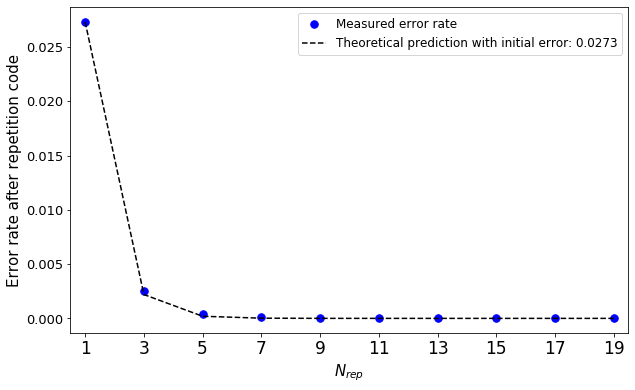

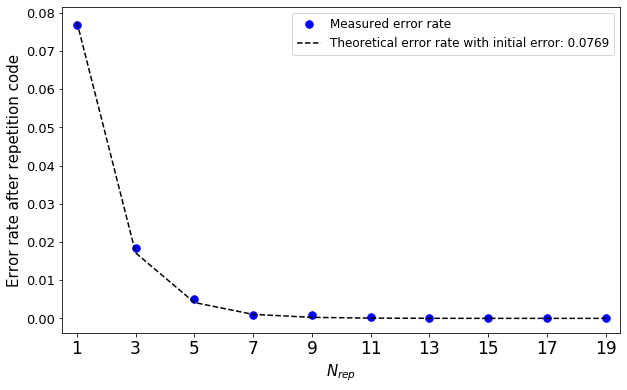

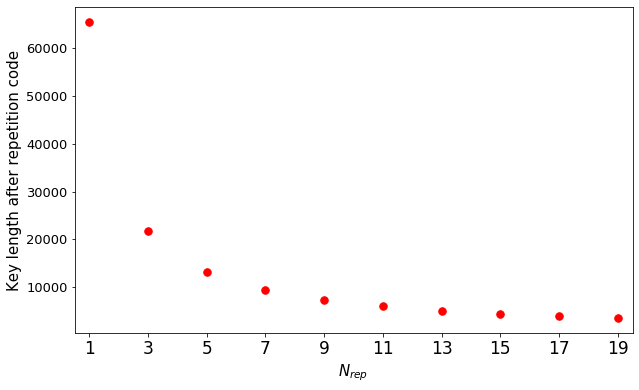

0.00012698670749477017
0.0005942652638950266


In [28]:
from scipy.optimize import curve_fit
#print(n_rep)
#print(err_rates)
print(n_rep)
n_repE91 = np.array([1,3,5,7,9,11,13,15,17,19])

err_ratesE91=[1-0.92309336,1-0.98150183,1-0.99481074,1-0.99914493,1-0.9991756,1-0.9996642,1-1,1-1,1-1,1-1]

var, cov = curve_fit(ProbOverallFailure, n_rep, err_rates)
print('A')
varE91, covE91 = curve_fit(ProbOverallFailure, n_repE91, err_ratesE91)
i = 0
theory_err_rates = np.zeros(len(n_rep))
theory_err_ratesE91 = np.zeros(len(n_rep))
for n in n_rep:
    theory_err_rates[i] = ProbOverallFailure1(int(n), var[0])
    theory_err_ratesE91[i] = ProbOverallFailure1(int(n), varE91[0])
    i+=1

default_x_ticks = range(n_rep[-1])
plt.figure(figsize=(10,6))
plt.plot(n_rep, err_rates, '.', markersize=15, c='b',label='Measured error rate')
plt.plot(n_rep, theory_err_rates, ls='--', c='k', label='Theoretical prediction with initial error: '+str(round(err_rates[0],4)))
plt.xlabel(r'$N_{rep}$',fontsize=15)
plt.ylabel('Error rate after repetition code', fontsize=15)
plt.xticks(n_rep, n_rep, fontsize=17)
plt.yticks(fontsize=13)
plt.xlim(0.5,19.5)
plt.legend(fontsize=12)
plt.savefig('BB84_ErrRatevsNrep.png')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(n_repE91, err_ratesE91, '.', markersize=15, c='b',label='Measured error rate')
plt.plot(n_repE91, theory_err_ratesE91, ls='--', c='k',label='Theoretical error rate with initial error: '+str(round(err_ratesE91[0],4)))
plt.xlabel(r'$N_{rep}$', fontsize=15)
plt.ylabel('Error rate after repetition code', fontsize=15)
plt.xticks(n_rep, n_rep, fontsize=17)
plt.xlim(0.5,19.5)
plt.legend(fontsize=12)
plt.yticks(fontsize=13)
plt.savefig('E91_ErrRatevsNrep.png')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(n_rep, key_lengths, '.', markersize=15, c='r')
#plt.yscale('log')
plt.xlabel(r'$N_{rep}$', fontsize=15)
plt.ylabel('Key length after repetition code', fontsize=15)
plt.xticks(n_rep, n_rep, fontsize=17)
plt.yticks(fontsize=13)
plt.xlim(0.5,19.5)
plt.savefig('KeyLengthvsNrep.png')
plt.show()

print(np.sqrt(cov[0,0]))
print(np.sqrt(covE91[0,0]))

In [109]:
%whos

Variable                      Type                          Data/Info
---------------------------------------------------------------------
AliceBas                      list                          n=131072
AliceKey                      ndarray                       3448: 3448 elems, type `float64`, 27584 bytes
AliceMess                     list                          n=131072
BB84Circuits                  function                      <function BB84Circuits at 0x0000019476B33D90>
BB84KeyConstruction           function                      <function BB84KeyConstruc<...>on at 0x0000019477309400>
BB84ProtocolQuantumRandom     function                      <function BB84ProtocolQua<...>om at 0x0000019476AE5E18>
BobBas                        list                          n=131072
BobKey                        ndarray                       3448: 3448 elems, type `float64`, 27584 bytes
ClassicalRegister             type                          <class 'qiskit.circuit.cl<...>ister.Classic

[ 1  3  5  7  9 11 13 15 17 19] [0.02897688 0.00434902 0.00076313 0.00021368 0.         0.
 0.         0.         0.         0.        ]


TypeError: only size-1 arrays can be converted to Python scalars

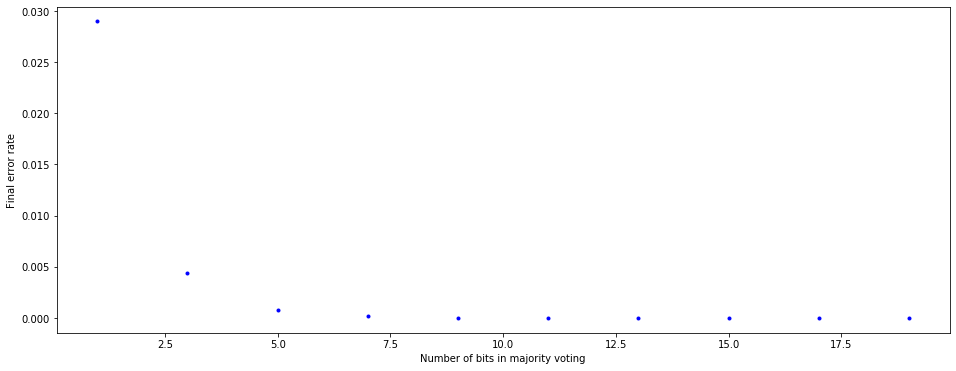

In [97]:
fig, ax = plt.subplots(figsize = (16,6))
n_repsE91 = [1,3,5,7,9,11,13,15,17,19]

ax.plot(n_rep, err_rates,'.',c='b',label='Eve doesnt listen')
#ax.plot(n_rep, err_rates25, '.', c='g', label='Eve listens 25%')
#ax.plot(n_rep, err_rates50, '.', c='r', label='Eve listens 50%')
#ax.plot(n_rep, err_rates75, '.', c='g', label='Eve listens 75%')
#ax.plot(n_rep, err_rates100, '.', c='r', label='Eve listens 100%')
#ax.plot(n_rep, err_rates99, '.', c='k', label='Eve listens 99%')
ax.set_xlabel('Number of bits in majority voting')
ax.set_ylabel('Final error rate')

#ax2 = ax.twinx()
#ax2.plot(n_rep, key_lengths, ls='--', c='r')
#ax2.set_ylabel('Key lengths',c='r')

Ntheory = 20
n_rep_theory = np.linspace(1,Ntheory,Ntheory)
overall_prob_array = np.zeros(Ntheory)


print(n_rep, err_rates)
var, cov = curve_fit(ProbOverallFailure, xdata=n_rep, ydata=err_rates)

for j in range(Ntheory):
    overall_prob_array[j] = ProbOverallFailure(var[0],int(n_rep[j]))
ax.plot(n_rep_theory,overall_prob_array,"--",label= "Theoretical prediction")
ax.legend()

In [68]:
print(key_lengths100)
print(key_lengths)

[16383.  5460.  3276.  2340.  1820.  1488.  1260.  1092.   960.   860.]
[16383.  5460.  3276.  2340.  1820.  1488.  1260.  1092.   960.   860.]


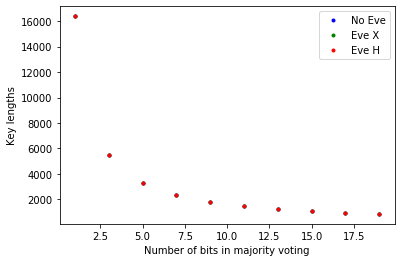

In [61]:
plt.figure()
plt.plot(n_rep, key_lengths, '.',c='b',label='No Eve')
plt.plot(n_rep, key_lengthsEX, '.',c='g',label='Eve X')
plt.plot(n_rep, key_lengthsEH, '.',c='r',label='Eve H')
plt.xlabel('Number of bits in majority voting')
plt.ylabel('Key lengths')
plt.legend()
plt.show()

In [42]:
EveProbs = np.linspace(0.1, 0.9, 9)
EveStrat = 'X'
Starmon5 = True
#raw_err_rates_Sim = [0.02606201171875, 0.0526123046875, 0.07421875, 0.0999755859375, 0.12445068359375, 0.14892578125, 0.17596435546875]
#raw_err_rates = [0.0508880615234375, 0.0771484375, 0.1067657470703125, 0.1338043212890625, 0.1603851318359375, 0.18499755859375, 0.2136993408203125, 0.2388153076171875, 0.2747650146484375,0]

for EveProb in [False]:
    succesRate, AliceMess, AliceBas, BobBas, Message = RawSuccesRateAnalyzer(EveProb,Starmon5,EveStrat)
    raw_err_rates.append(1-succesRate)

Progress: 0.0 %
Progress: 12.5 %
Progress: 25.0 %
Progress: 37.5 %
Progress: 50.0 %
Progress: 62.5 %
Progress: 75.0 %
Progress: 87.5 %
Succes rate: 0.97174072265625


In [70]:
raw_err_rates_Sim.insert(0,raw_err_rates_Sim[-1])
raw_err_rates_Sim = raw_err_rates_Sim[:-1]
print(raw_err_rates_Sim)

[0, 0.02606201171875, 0.0526123046875, 0.07421875, 0.0999755859375, 0.12445068359375, 0.14892578125, 0.17596435546875, 0.2078857421875, 0.2239990234375]


[0.0508880615234375, 0.0771484375, 0.1067657470703125, 0.1338043212890625, 0.1603851318359375, 0.18499755859375, 0.2136993408203125, 0.2388153076171875, 0.2747650146484375, 0, 0.02825927734375]


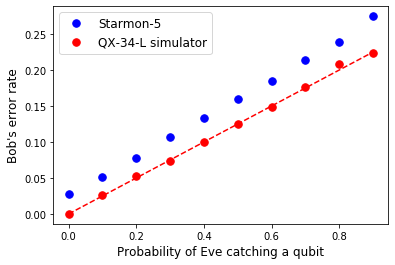

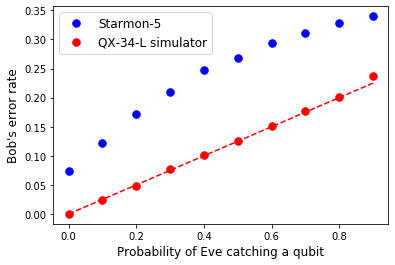

BB84:
On Starmon:   [0.02825927734375, 0.0508880615234375, 0.0771484375, 0.1067657470703125, 0.1338043212890625, 0.1603851318359375, 0.18499755859375, 0.2136993408203125, 0.2388153076171875, 0.2747650146484375]
On Simulator: [0, 0.02606201171875, 0.0526123046875, 0.07421875, 0.0999755859375, 0.12445068359375, 0.14892578125, 0.17596435546875, 0.2078857421875, 0.2239990234375]

E91:
On Starmon:   [0.07330322265625, 0.12118521806680727, 0.17115971515768058, 0.2093995023240528, 0.24794000959148976, 0.26790364583333337, 0.2932784008545052, 0.31186270285796347, 0.32779492048421555, 0.3399723730283658]
On Simulator: [0, 0.0238037109375, 0.048828125, 0.0770263671875, 0.10107421875, 0.12548828125, 0.1510009765625, 0.1761474609375, 0.2015380859375, 0.23779296875]


In [75]:
#EveProbs = np.append(EveProbs,0)
#raw_err_rates_Sim.append(0)
EveProbs = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#raw_err_rates_ = raw_err_rates[:-1]
#raw_err_rates_.append(raw_err_rates[-1])
raw_err_ratesE91 = [1-0.92669677734375,1-0.8788147819331927,1-0.8288402848423194,1-0.7906004976759472,1-0.75205999040851021,1-0.7320963541666666,1-0.7067215991454948,1-0.6881372971420365,1-0.6722050795157845,1-0.6600276269716342]
raw_err_rates_SimE91 = [0,1-0.9761962890625,1-0.951171875,1-0.9229736328125,1-0.89892578125,1-0.87451171875,1-0.8489990234375,1-0.8238525390625,1-0.7984619140625,1-0.76220703125]
#raw_err_rates_.insert(0,raw_err_rates_[-1])


def err_theory(p, f):
    return (1-f)*(1-3*p/4+p*f/2) + p/4

var, cov = curve_fit(err_theory, EveProbs, raw_err_rates_)
print(raw_err_rates)
plt.figure()
plt.plot(EveProbs, raw_err_rates_,'.',markersize=15,c='b', label='Starmon-5')
plt.plot(EveProbs, raw_err_rates_Sim,'.',markersize=15,c='r', label='QX-34-L simulator')
plt.plot(np.array(EveProbs), np.array(EveProbs)/4, c='r',ls='--')
#plt.yscale('log')
plt.xlabel('Probability of Eve catching a qubit', fontsize=12)
plt.ylabel("Bob's error rate", fontsize=12)
plt.legend(fontsize=12)
plt.savefig('RawError-EveProb.png')
plt.show()
var, cov = curve_fit(err_theory, EveProbs, raw_err_ratesE91)
plt.figure()
plt.plot(EveProbs, raw_err_ratesE91,'.',markersize=15,c='b', label='Starmon-5')
plt.plot(EveProbs, raw_err_rates_SimE91,'.',markersize=15,c='r', label='QX-34-L simulator')
plt.plot(np.array(EveProbs), np.array(EveProbs)/4, c='r', ls='--')
plt.xlabel('Probability of Eve catching a qubit', fontsize=12)
plt.ylabel("Bob's error rate", fontsize=12)
plt.legend(fontsize=12)
plt.savefig('RawError-EveProbE91.png')
plt.show()



print('BB84:')
print('On Starmon:  ',raw_err_rates_)
print('On Simulator:',raw_err_rates_Sim)
print('')
print('E91:')
print('On Starmon:  ',raw_err_ratesE91)
print('On Simulator:',raw_err_rates_SimE91)
